# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, isnan, col, max, lit
from pyspark.sql.types import IntegerType

import re
import datetime
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier, MultilayerPerceptronClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [6]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Nanodegree") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.persist() 

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# Check the size of the dataframe
df.count()

286500

In [8]:
# Check how the dataframe looks
df.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [9]:
#alternative it could have been done by using df.filter("userId is null").count() 
df.filter((df["userId"] == "") | df["userId"].isNull() | isnan(df["userId"])).count()

8346

In [10]:
df.groupBy("userId").count().orderBy("count", ascending=False).show()
#df.where(df.userId == "").groupBy("userId").count().show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
+------+-----+
only showing top 20 rows



In [11]:
df = df.filter(df["userId"] != "") # Dropna doesn't work df.dropna(how = "any", subset = ["userId"]).count()
df.count()

278154

In [12]:
df.dropDuplicates(["userId"]).groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [13]:
df.dropDuplicates(["userId"]).groupBy("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  177|
| paid|   48|
+-----+-----+



In [14]:
# Check for most popular artist. 
# Though despite that the most popular artist is "null", at this stage, it might not matter as a feature
df.groupBy("artist").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



In [15]:
df.groupBy("page").count().orderBy("count", ascending=False).show(50)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



Since there are not 'nulls' in the 'page' column I can proceed with a bit of confidence regarding using this column as a feature


In [16]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))
df = df.withColumn('registration_time', get_time('registration'))
df.select('userId', 'ts', 'registration_time').show(10)

+------+-------------+-------------------+
|userId|           ts|  registration_time|
+------+-------------+-------------------+
|    30|1538352117000|2018-09-28 22:22:42|
|     9|1538352180000|2018-09-30 18:20:30|
|    30|1538352394000|2018-09-28 22:22:42|
|     9|1538352416000|2018-09-30 18:20:30|
|    30|1538352676000|2018-09-28 22:22:42|
|     9|1538352678000|2018-09-30 18:20:30|
|     9|1538352886000|2018-09-30 18:20:30|
|    30|1538352899000|2018-09-28 22:22:42|
|    30|1538352905000|2018-09-28 22:22:42|
|    30|1538353084000|2018-09-28 22:22:42|
+------+-------------+-------------------+
only showing top 10 rows



In [17]:
# create churn label
#churn_event_func = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
churn_event_func = udf(lambda x: True if x == 'Cancellation Confirmation' else False)
#churn_event_func = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType()) # this results in labels of ints 1/0
downgrade_event_func = udf(lambda x: True if x == 'Submit Downgrade' else False)

# window over which to apply the event
windowval = Window.partitionBy('userId')

# label user who've ever churned
df = df \
    .withColumn('churn_event', churn_event_func('page'))\
    .withColumn('churn', max('churn_event').over(windowval))

df = df \
    .withColumn("downgraded_event", downgrade_event_func("page"))\
    .withColumn('downgraded', max('downgraded_event').over(windowval))

df.select('userId','churn','churn_event', 'downgraded_event', 'downgraded').show(10)

+------+-----+-----------+----------------+----------+
|userId|churn|churn_event|downgraded_event|downgraded|
+------+-----+-----------+----------------+----------+
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
|100010|false|      false|           false|     false|
+------+-----+-----------+----------------+----------+
only showing top 10 rows



In [18]:
df.dropDuplicates(["userId"]).select('userId','churn','churn_event', 'downgraded_event', 'downgraded').show(10)

+------+-----+-----------+----------------+----------+
|userId|churn|churn_event|downgraded_event|downgraded|
+------+-----+-----------+----------------+----------+
|100010|false|      false|           false|     false|
|200002|false|      false|           false|     false|
|   125| true|      false|           false|     false|
|   124|false|      false|           false|     false|
|    51| true|      false|           false|     false|
|     7|false|      false|           false|     false|
|    15|false|      false|           false|     false|
|    54| true|      false|           false|      true|
|   155|false|      false|           false|     false|
|100014| true|      false|           false|     false|
+------+-----+-----------+----------------+----------+
only showing top 10 rows



In [19]:
df.where(df.userId == '125').select('userId','churn','churn_event', 'downgraded_event', 'downgraded').show()

+------+-----+-----------+----------------+----------+
|userId|churn|churn_event|downgraded_event|downgraded|
+------+-----+-----------+----------------+----------+
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|      false|           false|     false|
|   125| true|       true|           false|     false|
+------+-----+-----------+----------------+----------+



In [20]:
df.dropDuplicates(["churn", "userId"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



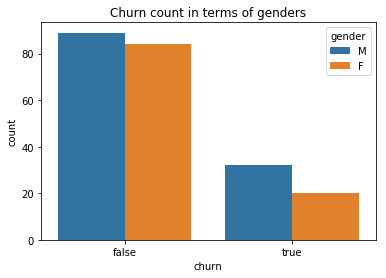

In [21]:
df_pd = df.dropDuplicates(["churn", "userId"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
ax = sns.barplot(x='churn', y='count', hue='gender', data=df_pd)
ax.set_title("Churn count in terms of genders");

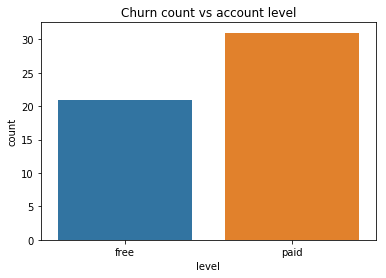

In [22]:
df_pd = df.filter(df.page=="Cancellation Confirmation").dropDuplicates(["churn", "userId"]).groupby("level").count().toPandas()
ax = sns.barplot(x="level", y="count", data=df_pd)
ax.set_title("Churn count vs account level");

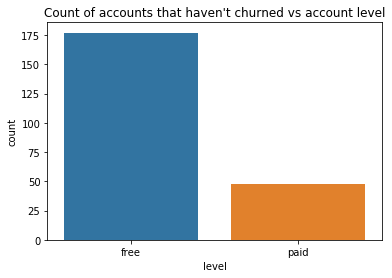

In [23]:
df_pd = df.filter(df.page != "Cancellation Confirmation").dropDuplicates(["churn", "userId"]).groupby("level").count().toPandas()
ax = sns.barplot(x="level", y="count", data=df_pd)
ax.set_title("Count of accounts that haven\'t churned vs account level");

In [24]:
lifetime_pd = df \
                .select('userId','registration','ts','churn') \
                .withColumn('lifetime',(df.ts-df.registration)) \
                .groupBy('userId','churn') \
                .agg({'lifetime':'max'}) \
                .withColumnRenamed('max(lifetime)','lifetime') \
                .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
                .toPandas()

In [25]:
lifetime_pd.describe()

,lifetime
count,225.000000
mean,79.845683
std,37.661470
min,0.313727
25%,59.125856
50%,73.004525
75%,100.378391
max,256.377674


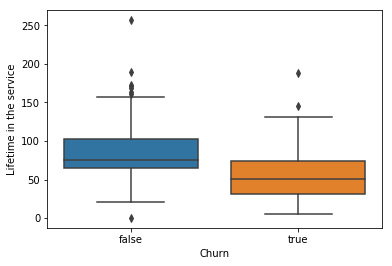

In [26]:
ax = sns.boxplot(data=lifetime_pd, x='churn', y='lifetime', orient='v')
plt.xlabel('Churn')
plt.ylabel('Lifetime in the service');

In [27]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- churn_event: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- downgraded_event: string (nullable = true)
 |-- downgraded: string (nullable = true)



In [28]:
df_file = "df_before_feat_eng"

In [29]:
df.write.mode('overwrite').save(df_file, format="csv", header=True)

In [30]:
df = spark.read.csv(df_file, header=True)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, time: string, registration_time: string, churn_event: string, churn: string, downgraded_event: string, downgraded: string]

In [31]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- churn_event: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- downgraded_event: string (nullable = true)
 |-- downgraded: string (nullable = true)



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [32]:
df_file = "df_before_feat_eng"

In [33]:
df = spark.read.csv(df_file, header=True)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, time: string, registration_time: string, churn_event: string, churn: string, downgraded_event: string, downgraded: string]

In [34]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- churn_event: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- downgraded_event: string (nullable = true)
 |-- downgraded: string (nullable = true)



In [35]:
# 1 Time since registration
feat_time_since_reg = df \
                        .select('userId','registration','ts') \
                        .withColumn('lifetime',(df.ts-df.registration)) \
                        .groupBy('userId') \
                        .agg({'lifetime':'max'}) \
                        .withColumnRenamed('max(lifetime)','lifetime') \
                        .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
feat_time_since_reg.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|  79.84568348765428|
| stddev|105396.47791907164|  37.66147001861255|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [36]:
# 2 Total songs listened
feat_total_songs = df \
                    .select('userID','song') \
                    .groupBy('userID') \
                    .count() \
                    .withColumnRenamed('count', 'total_songs')
feat_total_songs.describe().show()

+-------+------------------+-----------------+
|summary|            userID|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [37]:
# Number of Thumbs-Up
feat_thumbs_up = df \
                    .select('userID','page') \
                    .where(df.page == 'Thumbs Up') \
                    .groupBy('userID') \
                    .count() \
                    .withColumnRenamed('count', 'num_thumb_up') 
feat_thumbs_up.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [38]:
# Number of Thumbs-Down
feat_thumbs_down = df \
                    .select('userID','page') \
                    .where(df.page == 'Thumbs Down') \
                    .groupBy('userID') \
                    .count() \
                    .withColumnRenamed('count', 'num_thumb_down')
feat_thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [39]:
# Number of songs added to playlist
feat_songs_added = df \
                    .select('userID','page') \
                    .where(df.page == 'Add to Playlist') \
                    .groupBy('userID') \
                    .count() \
                    .withColumnRenamed('count', 'add_to_playlist')
feat_songs_added.describe().show()

+-------+------------------+-----------------+
|summary|            userID|  add_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [40]:
# Number of friends added
feat_friends = df \
                .select('userID','page') \
                .where(df.page == 'Add Friend') \
                .groupBy('userID') \
                .count() \
                .withColumnRenamed('count', 'add_friend') 
feat_friends.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [41]:
# Average number of songs listened per session
feat_number_songs_per_session = df.where('page == "NextSong"') \
                                    .groupby(['userId', 'sessionId']) \
                                    .count() \
                                    .groupby(['userId']) \
                                    .agg({'count':'avg'}) \
                                    .withColumnRenamed('avg(count)', 'avg_songs_played')
feat_number_songs_per_session.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [42]:
# Gender
feat_gender = df \
                .select("userId", "gender") \
                .dropDuplicates() \
                .replace(['M', 'F'], ['0', '1'], 'gender') \
                .select('userId', col('gender').cast('int'))
feat_gender.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [43]:
#number of sessions
feat_number_sessions = df \
                        .select("userId", "sessionId") \
                        .dropDuplicates() \
                        .groupby("userId") \
                        .count() \
                        .withColumnRenamed("count", "sessionCount")
feat_number_sessions.describe().show()

+-------+------------------+------------------+
|summary|            userId|      sessionCount|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|14.115555555555556|
| stddev|105396.47791907164|14.646884657111562|
|    min|                10|                 1|
|    max|                99|               107|
+-------+------------------+------------------+



label = df\
        .select("userId", col('churn').cast("int").alias('label')) \
        .dropDuplicates()
label.describe().show()

In [44]:
# window over which to apply the event
windowval = Window.partitionBy('userId')

In [45]:
#create downgrade 
downgrade_event_func = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
feat_downgrade = df \
                    .withColumn("downgraded_event", downgrade_event_func("page")) \
                    .withColumn("downgraded", max('downgraded_event').over(windowval)) \
                    .dropDuplicates(["userId"]) \
                    .select("userId","downgraded")
feat_downgrade.show(10)

+------+----------+
|userId|downgraded|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         0|
|   124|         0|
|    51|         0|
|     7|         0|
|    15|         0|
|    54|         1|
|   155|         0|
|100014|         0|
+------+----------+
only showing top 10 rows



In [46]:
feat_downgrade.groupby("downgraded").count().show()

+----------+-----+
|downgraded|count|
+----------+-----+
|         1|   49|
|         0|  176|
+----------+-----+



In [47]:
# create churn label
churn_event_func = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# label user who've ever churned
feat_label = df \
                .withColumn('churn_event', churn_event_func('page')) \
                .withColumn('churn', max('churn_event').over(windowval)) \
                .dropDuplicates(["userId"]) \
                .select("userId","churn") \
                .withColumnRenamed("churn", "label")


feat_label.show(10)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [48]:
feat_label.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [49]:
# data for modelling
data_withNA = feat_time_since_reg.join(feat_total_songs,'userID','outer') \
                .join(feat_thumbs_up,'userID','outer') \
                .join(feat_thumbs_down,'userID','outer') \
                .join(feat_songs_added,'userID','outer') \
                .join(feat_friends,'userID','outer') \
                .join(feat_number_songs_per_session,'userID','outer') \
                .join(feat_gender,'userID','outer') \
                .join(feat_number_sessions,'userID','outer') \
                .join(feat_label,'userID','outer') \

data_withNA.cache()
data_withNA.show(5)

+------+------------------+-----------+------------+--------------+---------------+----------+------------------+------+------------+-----+
|userId|          lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|  avg_songs_played|gender|sessionCount|label|
+------+------------------+-----------+------------+--------------+---------------+----------+------------------+------+------------+-----+
|100010|  55.6436574074074|        381|          17|             5|              7|         4|39.285714285714285|     1|           7|    0|
|200002| 70.07462962962963|        474|          21|             6|              8|         4|              64.5|     0|           6|    0|
|   125| 71.31688657407408|         11|        null|          null|           null|      null|               8.0|     0|           1|    1|
|   124|131.55591435185184|       4825|         171|            41|            118|        74|145.67857142857142|     1|          29|    0|
|    51|19.455844907

In [50]:
data_withNA.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [52]:
data_clean = data_withNA.na.drop(subset=data_withNA.columns)
data_clean.cache()

DataFrame[userId: string, lifetime: double, total_songs: bigint, num_thumb_up: bigint, num_thumb_down: bigint, add_to_playlist: bigint, add_friend: bigint, avg_songs_played: double, gender: int, sessionCount: bigint, label: int]

In [53]:
data_clean.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   43|
|    0|  149|
+-----+-----+



## Saving Data

In [54]:
data_withNA_file = "data_withNA_after_feat_eng"

In [55]:
data_withNA.write.mode('overwrite').save(data_withNA_file, format="csv", header=True)

In [56]:
data_withNA = spark.read.csv(data_withNA_file, header=True)
data_withNA.persist()

DataFrame[userId: string, lifetime: string, total_songs: string, num_thumb_up: string, num_thumb_down: string, add_to_playlist: string, add_friend: string, avg_songs_played: string, gender: string, sessionCount: string, label: string]

In [57]:
data_withNA.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lifetime: string (nullable = true)
 |-- total_songs: string (nullable = true)
 |-- num_thumb_up: string (nullable = true)
 |-- num_thumb_down: string (nullable = true)
 |-- add_to_playlist: string (nullable = true)
 |-- add_friend: string (nullable = true)
 |-- avg_songs_played: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- sessionCount: string (nullable = true)
 |-- label: string (nullable = true)



In [58]:
data_clean_file = "data_clean_after_feat_eng"

In [59]:
data_clean.write.mode('overwrite').save(data_clean_file, format="csv", header=True)

In [60]:
data_clean = spark.read.csv(data_clean_file, header=True)
data_clean.persist()

DataFrame[userId: string, lifetime: string, total_songs: string, num_thumb_up: string, num_thumb_down: string, add_to_playlist: string, add_friend: string, avg_songs_played: string, gender: string, sessionCount: string, label: string]

In [61]:
data_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lifetime: string (nullable = true)
 |-- total_songs: string (nullable = true)
 |-- num_thumb_up: string (nullable = true)
 |-- num_thumb_down: string (nullable = true)
 |-- add_to_playlist: string (nullable = true)
 |-- add_friend: string (nullable = true)
 |-- avg_songs_played: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- sessionCount: string (nullable = true)
 |-- label: string (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [7]:
data_clean_file = "data_clean_after_feat_eng"

In [8]:
data_clean = spark.read.csv(data_clean_file, header=True)
data_clean.persist()

DataFrame[userId: string, lifetime: string, total_songs: string, num_thumb_up: string, num_thumb_down: string, add_to_playlist: string, add_friend: string, avg_songs_played: string, gender: string, sessionCount: string, label: string]

In [9]:
data_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lifetime: string (nullable = true)
 |-- total_songs: string (nullable = true)
 |-- num_thumb_up: string (nullable = true)
 |-- num_thumb_down: string (nullable = true)
 |-- add_to_playlist: string (nullable = true)
 |-- add_friend: string (nullable = true)
 |-- avg_songs_played: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- sessionCount: string (nullable = true)
 |-- label: string (nullable = true)



In [10]:
feature_names = data_clean.drop("userId", "churn").columns
feature_names

['lifetime',
 'total_songs',
 'num_thumb_up',
 'num_thumb_down',
 'add_to_playlist',
 'add_friend',
 'avg_songs_played',
 'gender',
 'sessionCount',
 'label']

In [11]:
data_clean = data_clean.select(*(col(c).cast("float").alias(c) for c in feature_names)) \
                .drop("userId")

data_clean.cache()
data_clean.show(10)    

+---------+-----------+------------+--------------+---------------+----------+----------------+------+------------+-----+
| lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|avg_songs_played|gender|sessionCount|label|
+---------+-----------+------------+--------------+---------------+----------+----------------+------+------------+-----+
|62.095695|     3102.0|       135.0|          21.0|           72.0|      33.0|        88.86207|   0.0|        30.0|  0.0|
|120.89992|     1863.0|        72.0|          20.0|           51.0|      26.0|            92.0|   0.0|        19.0|  0.0|
|80.605125|     6880.0|       277.0|          75.0|          148.0|     143.0|       84.537315|   1.0|        71.0|  0.0|
|13.099016|     1102.0|        40.0|          13.0|           30.0|      12.0|       132.42857|   1.0|         7.0|  1.0|
| 95.33169|     2067.0|        87.0|          18.0|           53.0|      28.0|           108.0|   0.0|        17.0|  0.0|
|28.427696|      552.0| 

In [12]:
assembler = VectorAssembler(inputCols=data_clean.columns[:-1], outputCol="NumFeatures")
data_vector = assembler.transform(data_clean)
data_vector.show(10, True)

+---------+-----------+------------+--------------+---------------+----------+----------------+------+------------+-----+--------------------+
| lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|avg_songs_played|gender|sessionCount|label|         NumFeatures|
+---------+-----------+------------+--------------+---------------+----------+----------------+------+------------+-----+--------------------+
|62.095695|     3102.0|       135.0|          21.0|           72.0|      33.0|        88.86207|   0.0|        30.0|  0.0|[62.0956954956054...|
|120.89992|     1863.0|        72.0|          20.0|           51.0|      26.0|            92.0|   0.0|        19.0|  0.0|[120.899917602539...|
|80.605125|     6880.0|       277.0|          75.0|          148.0|     143.0|       84.537315|   1.0|        71.0|  0.0|[80.6051254272461...|
|13.099016|     1102.0|        40.0|          13.0|           30.0|      12.0|       132.42857|   1.0|         7.0|  1.0|[13.0990161895751...|

### Baseline Model

In [13]:
# train test split
train, rest = data_vector.select("NumFeatures", "label").randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

train = train.cache()
validation = validation.cache()
test = test.cache()

In [14]:
# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(train)
train_scaled = scalerModel.transform(train)
train_scaled.cache()

DataFrame[NumFeatures: vector, label: float, features: vector]

In [15]:
validation_scaled = scalerModel.transform(validation)
validation_scaled.cache()

DataFrame[NumFeatures: vector, label: float, features: vector]

In [16]:
test_scaled = scalerModel.transform(test)
test_scaled.cache()

DataFrame[NumFeatures: vector, label: float, features: vector]

In [17]:
train_scaled.show(5)
validation_scaled.show(5)
test_scaled.show(5)

+--------------------+-----+--------------------+
|         NumFeatures|label|            features|
+--------------------+-----+--------------------+
|[28.4276962280273...|  1.0|[-1.3531844345675...|
|[37.4382743835449...|  1.0|[-1.1183208124806...|
|[40.3575134277343...|  1.0|[-1.0422299064564...|
|[42.1323509216308...|  1.0|[-0.9959681954720...|
|[43.0526161193847...|  1.0|[-0.9719811866592...|
+--------------------+-----+--------------------+
only showing top 5 rows

+--------------------+-----+--------------------+
|         NumFeatures|label|            features|
+--------------------+-----+--------------------+
|[44.3144340515136...|  1.0|[-0.9390914958049...|
|[60.5883102416992...|  0.0|[-0.5149076708103...|
|[61.1763877868652...|  0.0|[-0.4995792401656...|
|[66.6266860961914...|  0.0|[-0.3575154590975...|
|[68.9053573608398...|  0.0|[-0.2981211585850...|
+--------------------+-----+--------------------+
only showing top 5 rows

+--------------------+-----+--------------------+


In [18]:
baseline_test_1 = test_scaled.withColumn('prediction', lit(1.0))
baseline_test_1.show(5)

+--------------------+-----+--------------------+----------+
|         NumFeatures|label|            features|prediction|
+--------------------+-----+--------------------+----------+
|[13.0990161895751...|  1.0|[-1.7527314174031...|       1.0|
|[19.4558448791503...|  1.0|[-1.5870386299647...|       1.0|
|[21.4514350891113...|  0.0|[-1.5350229283279...|       1.0|
|[27.3651618957519...|  0.0|[-1.3808797341989...|       1.0|
|[58.5386924743652...|  0.0|[-0.5683316181333...|       1.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows



In [19]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {:.3f}'.format(evaluator.evaluate(baseline_test_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{:.3f}'.format(evaluator.evaluate(baseline_test_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.206
F-1 Score:0.070


In [20]:
baseline_test_0 = test_scaled.withColumn('prediction', lit(0.0))
baseline_test_0.show(5)

+--------------------+-----+--------------------+----------+
|         NumFeatures|label|            features|prediction|
+--------------------+-----+--------------------+----------+
|[13.0990161895751...|  1.0|[-1.7527314174031...|       0.0|
|[19.4558448791503...|  1.0|[-1.5870386299647...|       0.0|
|[21.4514350891113...|  0.0|[-1.5350229283279...|       0.0|
|[27.3651618957519...|  0.0|[-1.3808797341989...|       0.0|
|[58.5386924743652...|  0.0|[-0.5683316181333...|       0.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows



In [21]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {:.3f}'.format(evaluator.evaluate(baseline_test_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{:.3f}'.format(evaluator.evaluate(baseline_test_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.794
F-1 Score:0.703


### Models function 

In [101]:
def model_tuning(model_name, model, data_train, data_test, paramGrid = ParamGridBuilder().build(), numFolds = 3):

    # set evaluator
    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    
    pipeline  = Pipeline(stages = [scaler, model])
    
    crossval = CrossValidator(estimator=pipeline,
                              evaluator=f1_evaluator, 
                              estimatorParamMaps=paramGrid,
                              numFolds = numFolds)
    start   = time()
    cvModel = crossval.fit(data_train)
    end     = time()
    print('The training process took {:.3f} seconds'.format(end - start))

    best_mod = cvModel.bestModel
    param_dict = best_mod.stages[-1].extractParamMap()

    sane_dict = {}
    for k, v in param_dict.items():
        sane_dict[k.name] = v
    print(model_name + ' best parameters')
    print(sane_dict)
    
    
    model_filename = model_name.replace(" ", "")+'_model'
    print ('Saving the model as:', model_filename)
    try:
        best_mod.write().overwrite().save(model_filename)
    except Exception as e: 
        print("Model Saving failed")
        print(e)        
    
    results = cvModel.transform(data_test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print(model_name+' Metrics:')
    print('Accuracy: {:.3f}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{:.3f}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))  
    return best_mod

In [102]:
# train test split
train, test = data_vector.select("NumFeatures", "label").randomSplit([0.6, 0.4], seed=42)
paramGrid = ParamGridBuilder().build()

### Logistic Regression

In [103]:
# I reduced the number of folds due having very little accessible data
lr       = LogisticRegression(maxIter = 100)
lr_model = model_tuning('Logistic Regression', lr, train, test, paramGrid = paramGrid, numFolds = 3)

The training process took 9.448 seconds
Logistic Regression best parameters
{'aggregationDepth': 2, 'elasticNetParam': 0.0, 'family': 'auto', 'featuresCol': 'features', 'fitIntercept': True, 'labelCol': 'label', 'maxIter': 100, 'predictionCol': 'prediction', 'probabilityCol': 'probability', 'rawPredictionCol': 'rawPrediction', 'regParam': 0.0, 'standardization': True, 'threshold': 0.5, 'tol': 1e-06}
Saving the model as: LogisticRegression_model
Logistic Regression Metrics:
Accuracy: 0.756
F-1 Score:0.734


### Gradient Boosted Trees

In [87]:
gbt       = GBTClassifier(maxIter=10, seed=42)
gbt_model = model_tuning('Gradient Boosted Trees', gbt, train, test,  paramGrid = paramGrid, numFolds = 3)

The training process took 23.221 seconds
Gradient Boosted Trees best parameters
{'cacheNodeIds': False, 'checkpointInterval': 10, 'featureSubsetStrategy': 'all', 'featuresCol': 'features', 'labelCol': 'label', 'lossType': 'logistic', 'maxBins': 32, 'maxDepth': 5, 'maxIter': 10, 'maxMemoryInMB': 256, 'minInfoGain': 0.0, 'minInstancesPerNode': 1, 'predictionCol': 'prediction', 'seed': 42, 'stepSize': 0.1, 'subsamplingRate': 1.0}
Saving the model as: GradientBoostedTrees_model
Gradient Boosted Trees Metrics:
Accuracy: 0.705
F-1 Score:0.695


### Random Forest

In [89]:
rfc       = RandomForestClassifier(seed=42)
rfc_model = model_tuning('Random Forest', rfc, train, test, paramGrid = paramGrid, numFolds = 3)

The training process took 6.773 seconds
Random Forest best parameters
{'cacheNodeIds': False, 'checkpointInterval': 10, 'featureSubsetStrategy': 'auto', 'featuresCol': 'features', 'impurity': 'gini', 'labelCol': 'label', 'maxBins': 32, 'maxDepth': 5, 'maxMemoryInMB': 256, 'minInfoGain': 0.0, 'minInstancesPerNode': 1, 'numTrees': 20, 'predictionCol': 'prediction', 'probabilityCol': 'probability', 'rawPredictionCol': 'rawPrediction', 'seed': 42, 'subsamplingRate': 1.0}
Saving the model as: RandomForest_model
Random Forest Metrics:
Accuracy: 0.731
F-1 Score:0.695


### Decision Tree Classifier

In [91]:
dtc       = DecisionTreeClassifier(seed=42)
dtc_model = model_tuning('Decision Tree Classifier', dtc, train, test, paramGrid = paramGrid, numFolds = 3)

The training process took 4.702 seconds
Decision Tree Classifier best parameters
{'cacheNodeIds': False, 'checkpointInterval': 10, 'featuresCol': 'features', 'impurity': 'gini', 'labelCol': 'label', 'maxBins': 32, 'maxDepth': 5, 'maxMemoryInMB': 256, 'minInfoGain': 0.0, 'minInstancesPerNode': 1, 'predictionCol': 'prediction', 'probabilityCol': 'probability', 'rawPredictionCol': 'rawPrediction', 'seed': 42}
Saving the model as: DecisionTreeClassifier_model
Decision Tree Classifier Metrics:
Accuracy: 0.731
F-1 Score:0.714


### Fine Tuning the best model

In [100]:
lr           = LogisticRegression()
paramGrid_lr = ParamGridBuilder()\
                .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
                .addGrid(lr.fitIntercept,[False, True])\
                .addGrid(lr.regParam,[0.1, 0.5, 2.0]) \
                .addGrid(lr.maxIter,[100])\
                .build()
lr_model_tuned = model_tuning('Logistic Regression Tuned Model', lr, train, test, paramGrid = paramGrid_lr, numFolds = 3)

The training process took 45.359 seconds
Logistic Regression Tuned Model best parameters
{'aggregationDepth': 2, 'elasticNetParam': 0.0, 'family': 'auto', 'featuresCol': 'features', 'fitIntercept': True, 'labelCol': 'label', 'maxIter': 100, 'predictionCol': 'prediction', 'probabilityCol': 'probability', 'rawPredictionCol': 'rawPrediction', 'regParam': 0.1, 'standardization': True, 'threshold': 0.5, 'tol': 1e-06}
Saving the model as: LogisticRegressionTunedModel_model
Logistic Regression Tuned Model Metrics:
Accuracy: 0.782
F-1 Score:0.698


In [108]:
lr           = LogisticRegression()
paramGrid_lr = ParamGridBuilder()\
                .addGrid(lr.maxIter,[100])\
                .build()
lr_model     = model_tuning('Logistic Regression Tuned Model', lr, train, test, paramGrid = paramGrid_lr, numFolds = 3)

The training process took 9.326 seconds
Logistic Regression Tuned Model best parameters
{'aggregationDepth': 2, 'elasticNetParam': 0.0, 'family': 'auto', 'featuresCol': 'features', 'fitIntercept': True, 'labelCol': 'label', 'maxIter': 100, 'predictionCol': 'prediction', 'probabilityCol': 'probability', 'rawPredictionCol': 'rawPrediction', 'regParam': 0.0, 'standardization': True, 'threshold': 0.5, 'tol': 1e-06}
Saving the model as: LogisticRegressionTunedModel_model
Logistic Regression Tuned Model Metrics:
Accuracy: 0.756
F-1 Score:0.734


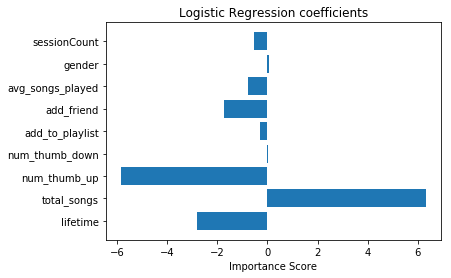

In [113]:
feat_imp = lr_model.stages[-1].coefficients
cols = data_clean.columns[:-1]
y_pos = range(len(cols))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('Logistic Regression coefficients');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.